# Exploratory Data Analysis

## Libraries

In [1]:
import os
os.chdir("input")

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [ ]:
def visualize_num_var(df: pd.DataFrame, var: str, target: str = None) -> None:
    """ Histogram and Boxplot for numerical variables.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        var (str): The numerical variable to visualize.
        target (str, optional): The output variable to use as hue. Defaults to None.
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

    hist_kwargs = {"data": df, "x": var, "kde": True, "ax": ax[0], "palette": "Set1"}
    box_kwargs = {"data": df, "x": var, "ax": ax[1], "orient": "h"}

    if target:
        hist_kwargs["hue"] = target
        box_kwargs["y"] = target
        box_kwargs["palette"] = "Set1"
    else:
        box_kwargs["x"] = var

    sns.histplot(**hist_kwargs)
    ax[0].set_title(f"{var} Histplot")

    sns.boxplot(**box_kwargs)
    ax[1].set_title(f"{var} Boxplot")

    plt.tight_layout()
    plt.show()


def visualize_cat_var(df: pd.DataFrame, var: str, target: str = None) -> None:
    """ Countplot for categorical variables.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        var (str): The categorical variable to visualize.
        output (str, optional): The output variable to use as hue. Defaults to None.
    """
    plt.figure(figsize=(6, 6))
    if target:
        ax = sns.countplot(data=df, x=var, hue=target, palette="Set1")
    else:
        ax = sns.countplot(data=df, x=var, palette="Set1")

    for p in ax.patches:
        if p.get_height() > 0:
            count = int(p.get_height())
            x = p.get_x() + p.get_width() / 2
            ax.annotate(f"{count}", (x, p.get_height()), ha="center", va="bottom", fontsize=10)

    plt.title(f"Countplot of {var}" + (f" by {target}" if target else ""))
    plt.xlabel(var)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def shapiro_wilk_normality(df: pd.DataFrame, num_vars: list[str], significance_level: float = 0.05) -> pd.DataFrame:
    """ Shapiro Wilk Normality Test to see if the numerical variables are normally distributed.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        num_vars (list): List of numerical variables.
        significance_level (float, optional): Threshold for significance. Defaults to 0.05.

    Returns:
        pd.DataFrame: Styled DataFrame with p-values highlighted.
    """
    shapiro = {col: st.shapiro(df[col])[1] for col in num_vars}
    
    shapiro_df = pd.DataFrame(list(shapiro.items()), columns=["Variable", "p-value"])
    
    shapiro_df_styled = shapiro_df.style.applymap(
        lambda val: "background-color: yellow" if val < significance_level else "",
        subset=["p-value"]
    )
    
    return shapiro_df_styled


def mann_whitney_u(df: pd.DataFrame, num_vars: list[str], target: str, significance_level: float = 0.05, effect_size_threshold: float = 0.5) -> pd.DataFrame:
    """ Mann-Whitney U test to compare distributions of numerical variables based on target groups.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        num_vars (list[str]): List of numerical variable names.
        target (str): The target variable to separate the groups (0 and 1).
        significance_level (float, optional): Threshold for significance. Defaults to 0.05.
        effect_size_threshold (float, optional): Threshold for effect size to highlight. Defaults to 0.5.

    Returns:
         pd.DataFrame: Styled DataFrame with p-values and effect sizes highlighted.
    """
    results = []

    target_0 = df[df[target] == 0]
    target_1 = df[df[target] == 1]

    for var in num_vars:
        stat, p_value = st.mannwhitneyu(target_0[var], target_1[var], alternative="two-sided")
        n1, n2 = len(target_0), len(target_1)
        effect_size = abs(stat - (n1 * n2) / 2) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    
        results.append({
            "Variable": var,
            "U-Statistic": stat,
            "p-value": p_value,
            "Effect Size (r)": effect_size
        })

    results_df = pd.DataFrame(results)

    styled_results_df = results_df.style.applymap(
        lambda val: "background-color: yellow" if isinstance(val, (float, int)) and val < significance_level else "",
        subset=["p-value"]
    )
    styled_results_df = styled_results_df.applymap(
        lambda val: "background-color: lightgreen" if isinstance(val, (float, int)) and val >= effect_size_threshold else "",
        subset=["Effect Size (r)"]
    )

    return styled_results_df

def chi_2(df: pd.DataFrame, cat_vars: list[str], target: str) -> pd.DataFrame:
    """ Performs the Chi-Square test to assess the association between categorical variables and a binary target.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        cat_vars (list[str]): List of categorical variable names.
        target (str): The target variable to separate the groups (0 and 1).

    Returns:
        pd.DataFrame: Styled DataFrame with p-values highlighted.
    """
    results = []

    for var in cat_vars:
        contingency_table = pd.crosstab(df[var], df[target])

        chi2, p_value, _, _ = st.chi2_contingency(contingency_table)

        results.append({
            "Variable": var,
            "Chi2": chi2,
            "p-value": p_value,
        })

    results_df = pd.DataFrame(results)
    styled_results_df = results_df.style.applymap(
        lambda val: "background-color: yellow" if isinstance(val, (float, int)) and val < 0.05 else "",
        subset=["p-value"]
    )

    return styled_results_df

## Data Reading & Inspection

In [3]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset contains the following columns:

- **age**: The person’s age in years
- **sex**: The person’s sex (1 = male, 0 = female)
- **cp**: Chest pain type
  - Value 0: Asymptomatic
  - Value 1: Atypical angina
  - Value 2: Non-anginal pain
  - Value 3: Typical angina
- **trestbps**: The person’s resting blood pressure (mm Hg on admission to the hospital)
- **chol**: The person’s cholesterol measurement in mg/dl
- **fbs**: Fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- **restecg**: Resting electrocardiographic results
  - Value 0: Showing probable or definite left ventricular hypertrophy by Estes’ criteria
  - Value 1: Normal
  - Value 2: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- **thalach**: The person’s maximum heart rate achieved
- **exang**: Exercise induced angina (1 = yes; 0 = no)
- **oldpeak**: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot)
- **slope**: The slope of the peak exercise ST segment
  - Value 0: Downsloping
  - Value 1: Flat
  - Value 2: Upsloping
- **ca**: The number of major vessels (0–3)
- **thal**: A blood disorder called thalassemia
  - Value 0: NULL (dropped from the dataset previously)
  - Value 1: Fixed defect (no blood flow in some part of the heart)
  - Value 2: Normal blood flow
  - Value 3: Reversible defect (blood flow observed but not normal)
- **target**: Heart disease (0 = no, 1 = yes)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [6]:
num_vars = ["age", "trtbps", "chol", "thalachh", "oldpeak"]
cat_vars = ["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall"]
target = "output"

## Data Visualization

### Univariate

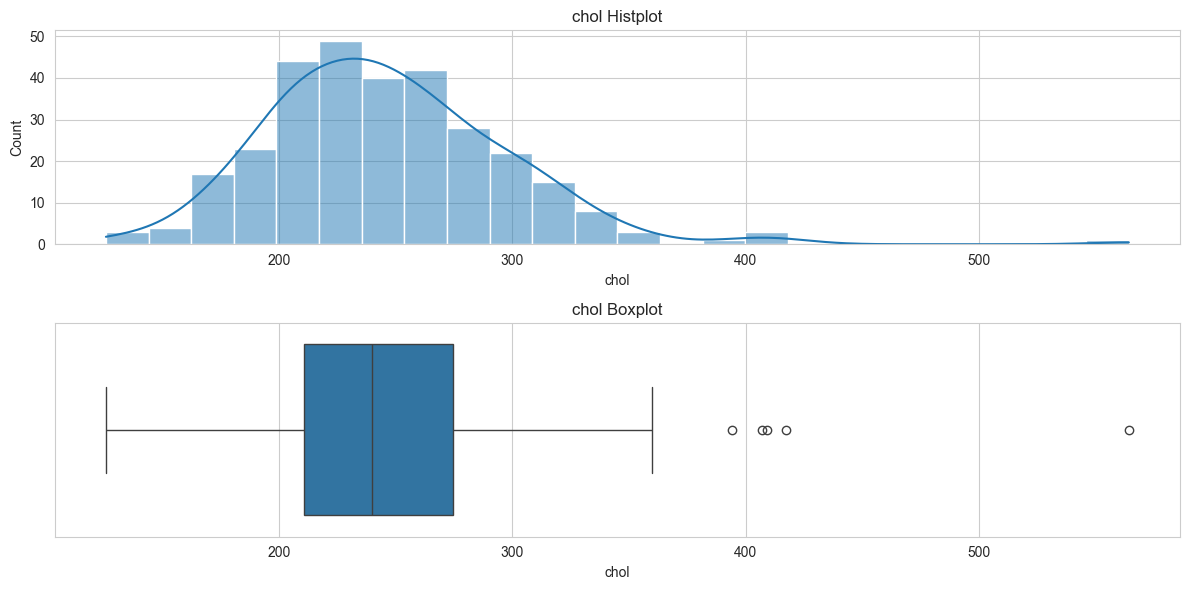

In [68]:
visualize_num_var(df, "chol")

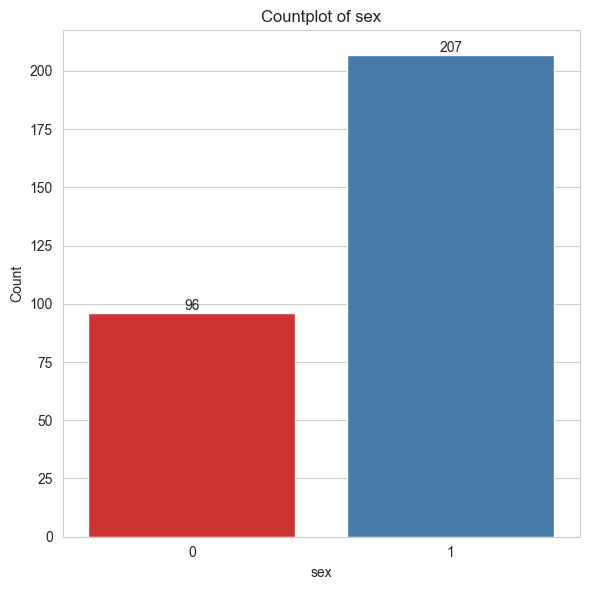

In [8]:
visualize_cat_var(df, "sex")

### Bivariate

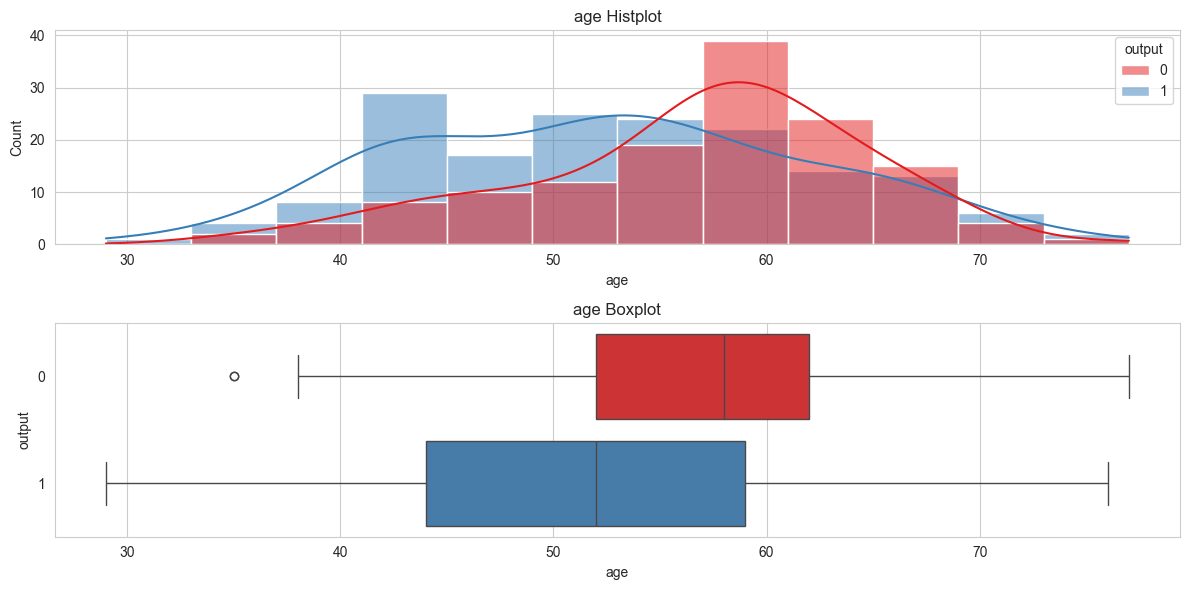

In [9]:
visualize_num_var(df, "age", "output")

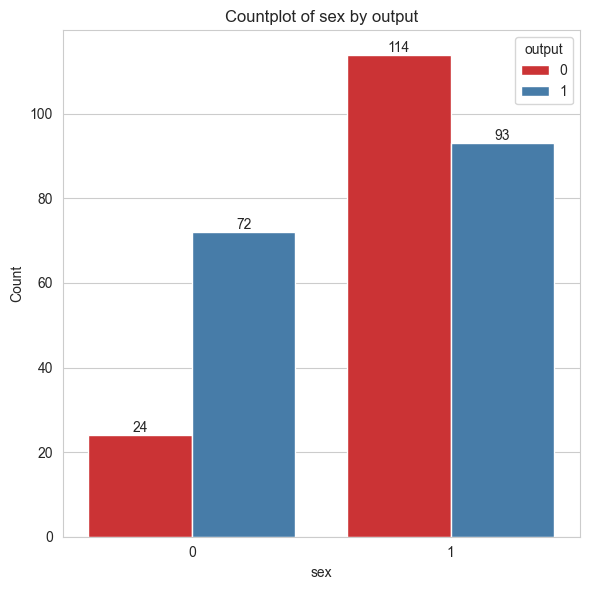

In [10]:
visualize_cat_var(df, "sex", "output")

### Multivariate

In [11]:
df.groupby(["sex", "cp", "output"])["age"].mean()

sex  cp  output
0    0   0         59.047619
         1         55.166667
     1   0         57.500000
         1         51.250000
     2   0         62.000000
         1         54.764706
     3   1         63.250000
1    0   0         55.602410
         1         53.142857
     1   0         57.428571
         1         49.240000
     2   0         58.294118
         1         49.742857
     3   0         55.142857
         1         53.833333
Name: age, dtype: float64

## Statistical Tests

In [12]:
# Correlation
df[num_vars].corr(method="spearman").style.applymap(lambda val: "background-color: yellow" if abs(val) >= 0.7 else "")

,age,trtbps,chol,thalachh,oldpeak
age,1.000000,0.285617,0.195786,-0.398052,0.268291
trtbps,0.285617,1.000000,0.126562,-0.040407,0.154267
chol,0.195786,0.126562,1.000000,-0.046766,0.045260
thalachh,-0.398052,-0.040407,-0.046766,1.000000,-0.433241
oldpeak,0.268291,0.154267,0.045260,-0.433241,1.000000


In [13]:
skew_kurt_df = pd.DataFrame({
    "Skewness": df[num_vars].skew(),
    "Kurtosis": df[num_vars].kurt()
})
skew_kurt_df

,Skewness,Kurtosis
age,-0.202463,-0.542167
trtbps,0.713768,0.929054
chol,1.143401,4.505423
thalachh,-0.537410,-0.061970
oldpeak,1.269720,1.575813


In [14]:
swn_df = shapiro_wilk_normality(df, num_vars)
swn_df

,Variable,p-value
0,age,0.005798
1,trtbps,0.000001
2,chol,0.000000
3,thalachh,0.000066
4,oldpeak,0.000000


None of the continuous variables are normally distributed.
We will use non-parametric tests.

In [15]:
mwu_df = mann_whitney_u(df, num_vars, "output")
mwu_df

,Variable,U-Statistic,p-value,Effect Size (r)
0,age,14529.500000,0.000034,4.140225
1,trtbps,12985.500000,0.034652,2.107308
2,chol,12980.500000,0.035715,2.100725
3,thalachh,5732.000000,0.000000,7.443056
4,oldpeak,16848.000000,0.000000,7.192892


In [16]:
chi_2_df = chi_2(df, cat_vars, "output")
chi_2_df

,Variable,Chi2,p-value
0,sex,22.717227,0.000002
1,cp,81.686428,0.000000
2,fbs,0.106273,0.744428
3,restecg,10.023092,0.006661
4,exng,55.944550,0.000000
5,slp,47.506897,0.000000
6,caa,74.366631,0.000000
7,thall,85.303740,0.000000


## Feature Selection via Random Forest

In [18]:
X = df.drop("output", axis=1)
y = df["output"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
accuracy_before = rf.score(X_test, y_test)
print(f'Accuracy before feature selection: {accuracy_before:.3f}')

Accuracy before feature selection: 0.836


In [48]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

     Feature  Importance
2         cp    0.157024
7   thalachh    0.117595
9    oldpeak    0.113267
12     thall    0.107326
4       chol    0.086923
11       caa    0.085566
0        age    0.078193
3     trtbps    0.074041
10       slp    0.059483
8       exng    0.058643
1        sex    0.030452
6    restecg    0.021585
5        fbs    0.009901


In [59]:
accuracy = {}
for i in range(1, X.shape[1] + 1):
    top_features = feature_importance_df['Feature'][:i].values
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selected.fit(X_train_selected, y_train)
    accuracy[i] = rf_selected.score(X_test_selected, y_test)

In [60]:
pd.DataFrame(accuracy.items(), columns=["Number of Features", "Accuracy"]).set_index("Number of Features")

,Accuracy
Number of Features,
1,0.704918
2,0.655738
3,0.721311
4,0.770492
5,0.754098
6,0.786885
7,0.786885
8,0.836066
9,0.803279


In [63]:
top_features[:8]

array(['cp', 'thalachh', 'oldpeak', 'thall', 'chol', 'caa', 'age',
       'trtbps'], dtype=object)